In [1]:
import random
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.utils import resample
from sklearn import cluster
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split, WeightedRandomSampler
import torch

from wquantiles import quantile_1D

import matplotlib.pyplot as plt
import pdb

import pickle
import os
import csv

class ConfigStruct:
    def __init__(self, **entries):
        self.__dict__.update(entries)

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cuda


In [3]:
config = dict(
    epochs=100,
    batch_size=2048,
    learning_rate=0.008, # 0.0005 ?!
    weight_decay=1e-5,
    dropout=0.5,  # 0.05 ?!
    shuffle=True,
    test_size=0.2,  # 0.2 ?!
    split_seed=42,
    random_seed=1234,
    top10_apps_filter=False,
    only_duplicates=False,
    meancount75_filter=False,
    isolation_forest_train=False,
    isolation_forest_val=False,
    isolation_forest_test=False,
    feature_agglomeration=False,
    feature_agglomeration_nclusters=64,
    stratified_split=False,
    smooth_l1_loss_beta=1
)

In [4]:
config = ConfigStruct(**config)

In [5]:
MODEL_FILENAME = "Model_D"
MODEL_DIR = r"../models"
MODEL_PATH = Path(MODEL_DIR, MODEL_FILENAME).with_suffix(".pth")
MODEL_TUNED_PATH = Path(MODEL_DIR, MODEL_FILENAME + "_(finetuned)").with_suffix(".pth")

DATASET_DIR = r"../data/"
DATASET_NAME = "theta_posix_with_apps_no_negative_outliers_no_time_witherrors"
DATASET_PATH = Path(DATASET_DIR, DATASET_NAME).with_suffix(".csv")

PICKLE_DIR = r"../models/pickle"
FEATUREAGGLO_NAME = r"Model_D_(finetuned)_featureagglomeration"
FEATUREAGGLO_PATH = Path(PICKLE_DIR, FEATUREAGGLO_NAME).with_suffix(".pkl")

ROBUSTSCALER_NAME = r"Model_D_(finetuned)_robustscaler"
ROBUSTSCALER_PATH = Path(PICKLE_DIR, ROBUSTSCALER_NAME).with_suffix(".pkl")

ISOLATIONFOREST_NAME = r"Model_D_(finetuned)_isolationforest"
ISOLATIONFOREST_PATH = Path(PICKLE_DIR, ISOLATIONFOREST_NAME).with_suffix(".pkl")

INTERPRETABILITY_DIR = r"../interpretability/captum"

CSV_LOG_PATH = "../results/training/Model_D_(finetuned)_test_loss.csv"

In [6]:
# Fix seeds for reproducibility
random.seed(config.random_seed)
np.random.seed(config.random_seed)

torch.manual_seed(config.random_seed)
torch.cuda.manual_seed_all(config.random_seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [7]:
if not os.path.exists(CSV_LOG_PATH):
    with open(CSV_LOG_PATH, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["epoch", "test_loss"])

In [8]:
# Load the data
df_blue_waters_posix = pd.read_csv(DATASET_PATH)
df_blue_waters_posix

,index,POSIX_OPENS,POSIX_FILENOS,POSIX_DUPS,POSIX_READS,POSIX_WRITES,POSIX_SEEKS,POSIX_STATS,POSIX_MMAPS,POSIX_FSYNCS,...,WRITE_10M_100M,WRITE_100M_1G,WRITE_1G_PLUS,rank,POSIX_TOTAL_TIME,nprocs,lustre,exe,mean,error
0,0,7891771,7861736,0,3,424661,60035,90055,0,0,...,0,0,0,0,29.684507,64,1,cp2k.psmp,31.913841,-2.229334
1,1,194,172,0,34,1499,6,54,0,0,...,0,0,0,0,28.155456,16,1,pw.x,11.403251,16.752206
2,2,46037,40869,0,4713059,1719073,1271774,5429,0,0,...,0,0,0,-1,71229.030892,128,1,train.x-2.0.3-ifort_intelmpi,NaN,0.000000
3,3,194,172,0,34,1492,6,54,0,0,...,0,0,0,2,1.707640,16,1,pw.x,6.519022,-4.811382
4,4,7891771,7861736,0,3,424661,60035,90055,0,0,...,0,0,0,0,34.010366,64,1,cp2k.psmp,33.631730,0.378636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218106,218106,618,0,0,15040,10450,21,1555,0,0,...,0,0,0,-1,6.904750,64,1,vasp_ncl,NaN,0.000000
218107,218107,68,-22,-22,7829,0,0,116,0,0,...,0,0,0,-1,1.194060,16,1,pw.x,1.221651,-0.027592
218108,218108,34713,34116,0,8745,49849,240,504,-335,0,...,0,0,0,-1,220.660687,96,1,qmcpack,NaN,0.000000
218109,218109,68,-22,-22,7829,0,0,116,0,0,...,0,0,0,-1,1.274516,16,1,pw.x,1.221651,0.052865


In [9]:
# df_blue_waters_posix = df_blue_waters_posix[df_blue_waters_posix['exe'] == 'cp2k.psmp'].head(4)
# filtered_df

cp2k_df = df_blue_waters_posix[df_blue_waters_posix['exe'] == 'cp2k.psmp']
df_blue_waters_posix = cp2k_df.sample(n=4, random_state=42)
df_blue_waters_posix

,index,POSIX_OPENS,POSIX_FILENOS,POSIX_DUPS,POSIX_READS,POSIX_WRITES,POSIX_SEEKS,POSIX_STATS,POSIX_MMAPS,POSIX_FSYNCS,...,WRITE_10M_100M,WRITE_100M_1G,WRITE_1G_PLUS,rank,POSIX_TOTAL_TIME,nprocs,lustre,exe,mean,error
28856,28856,7838128,7815866,0,195,3924375,44202,66520,0,0,...,0,0,0,0,25.557728,64,1,cp2k.psmp,NaN,0.0
15390,15390,7838128,7815866,0,195,3924397,44202,66520,0,0,...,0,0,0,0,25.470067,64,1,cp2k.psmp,NaN,0.0
2947,2947,7848124,7824434,0,195,3947971,47038,70532,0,0,...,0,0,0,0,81.565449,64,1,cp2k.psmp,NaN,0.0
34567,34567,7838128,7815866,0,195,3924269,44202,66520,0,0,...,0,0,0,0,24.799469,64,1,cp2k.psmp,NaN,0.0


In [10]:
# df_blue_waters_posix = pd.concat([df_blue_waters_posix[df_blue_waters_posix['exe'] != 'cp2k.psmp'], filtered_df.head(5)])
# df_blue_waters_posix

In [11]:
df_blue_waters_posix = df_blue_waters_posix.drop(['exe', 'lustre', 'index'],axis=1)
df_blue_waters_posix.head()

,POSIX_OPENS,POSIX_FILENOS,POSIX_DUPS,POSIX_READS,POSIX_WRITES,POSIX_SEEKS,POSIX_STATS,POSIX_MMAPS,POSIX_FSYNCS,POSIX_RENAME_SOURCES,...,WRITE_1M_4M,WRITE_4M_10M,WRITE_10M_100M,WRITE_100M_1G,WRITE_1G_PLUS,rank,POSIX_TOTAL_TIME,nprocs,mean,error
28856,7838128,7815866,0,195,3924375,44202,66520,0,0,0,...,0,0,0,0,0,0,25.557728,64,NaN,0.0
15390,7838128,7815866,0,195,3924397,44202,66520,0,0,0,...,0,0,0,0,0,0,25.470067,64,NaN,0.0
2947,7848124,7824434,0,195,3947971,47038,70532,0,0,24,...,0,0,0,0,0,0,81.565449,64,NaN,0.0
34567,7838128,7815866,0,195,3924269,44202,66520,0,0,0,...,0,0,0,0,0,0,24.799469,64,NaN,0.0


In [12]:
# Just fine tune with quantum espresso data
# df_blue_waters_posix = df_blue_waters_posix[df_blue_waters_posix.exe.str.contains("pw.x")]
# df_blue_waters_posix.shape

In [13]:
if config.top10_apps_filter:
    apps_count_series = df_blue_waters_posix.groupby(by=["exe"]).count()["nprocs"].sort_values(ascending=False)
    df_blue_waters_posix = df_blue_waters_posix[df_blue_waters_posix.exe.isin(apps_count_series[0:10].index)]

In [14]:
if config.only_duplicates:
    df_blue_waters_posix = df_blue_waters_posix[df_blue_waters_posix["mean"].isna() == False]

In [15]:
if config.meancount75_filter:
    mean_counts = df_blue_waters_posix.groupby("mean",dropna=False)["mean"].transform("count")
    mean_counts_quantile = pd.Series(mean_counts.unique()).quantile(0.75)
    df_blue_waters_posix = df_blue_waters_posix[df_blue_waters_posix.index.isin(mean_counts[mean_counts > mean_counts_quantile].index)]

In [16]:
# Separate bandwidth from input features
POSIX_TOTAL_TIME_df = df_blue_waters_posix.pop('POSIX_TOTAL_TIME')
POSIX_TOTAL_TIME_df.head()

28856    25.557728
15390    25.470067
2947     81.565449
34567    24.799469
Name: POSIX_TOTAL_TIME, dtype: float64

In [17]:
# Separate duplicate set mean from input features and drop errors
dup_set_means_df = df_blue_waters_posix.pop('mean')

In [18]:
df_blue_waters_posix = df_blue_waters_posix.drop(["error"], axis=1)
df_blue_waters_posix.head()

,POSIX_OPENS,POSIX_FILENOS,POSIX_DUPS,POSIX_READS,POSIX_WRITES,POSIX_SEEKS,POSIX_STATS,POSIX_MMAPS,POSIX_FSYNCS,POSIX_RENAME_SOURCES,...,WRITE_1K_10K,WRITE_10K_100K,WRITE_100K_1M,WRITE_1M_4M,WRITE_4M_10M,WRITE_10M_100M,WRITE_100M_1G,WRITE_1G_PLUS,rank,nprocs
28856,7838128,7815866,0,195,3924375,44202,66520,0,0,0,...,0,0,0,0,0,0,0,0,0,64
15390,7838128,7815866,0,195,3924397,44202,66520,0,0,0,...,0,0,0,0,0,0,0,0,0,64
2947,7848124,7824434,0,195,3947971,47038,70532,0,0,24,...,0,0,0,0,0,0,0,0,0,64
34567,7838128,7815866,0,195,3924269,44202,66520,0,0,0,...,0,0,0,0,0,0,0,0,0,64


In [19]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(df_blue_waters_posix,
                                                    POSIX_TOTAL_TIME_df,
                                                    test_size=config.test_size,
                                                    random_state=config.split_seed,
                                                    stratify=df_blue_waters_posix["nprocs"] if config.stratified_split else None)

In [20]:
agglo = cluster.FeatureAgglomeration(n_clusters=config.feature_agglomeration_nclusters)
agglo.fit(df_blue_waters_posix)
with open(FEATUREAGGLO_PATH,'wb') as f:
    pickle.dump(agglo,f)

In [21]:
if config.feature_agglomeration:
    X_train = agglo.transform(X_train)
    X_val = agglo.transform(X_val)

In [22]:
# Scale the input features with RobustScaler
scaler = RobustScaler().fit(X_train)

In [23]:
with open(ROBUSTSCALER_PATH,'wb') as f:
    pickle.dump(scaler,f)

In [24]:
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [25]:
tensor_X_train = torch.Tensor(X_train_scaled).to(device)
tensor_y_train = torch.Tensor(y_train.values).view(-1, 1).to(device)

In [26]:
training_dataset = TensorDataset(tensor_X_train, tensor_y_train)

In [27]:
# If shuffle disabled, use weighted random sampling
if config.shuffle:
    training_dataloader = DataLoader(training_dataset, batch_size=config.batch_size, shuffle=config.shuffle)
else:
    training_dataloader = DataLoader(training_dataset, batch_size=config.batch_size, sampler=sampler)

In [28]:
tensor_X_val = torch.Tensor(X_val_scaled).to(device)
tensor_y_val = torch.Tensor(y_val.values).view(-1, 1).to(device)

In [29]:
validation_dataset = TensorDataset(tensor_X_val, tensor_y_val)
validation_dataloader = DataLoader(validation_dataset, batch_size=config.batch_size)  #, shuffle=config.shuffle)

In [30]:
model = nn.Sequential(
    nn.Linear(config.feature_agglomeration_nclusters if config.feature_agglomeration else 89, 512),
    nn.Dropout(p=config.dropout),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.Dropout(p=config.dropout),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.Dropout(p=config.dropout),
    nn.ReLU(),
    nn.Linear(128, 1)
).to(device)

In [31]:
# By default Pytorch returns avg loss per minibatch elements. But since the last batch
# (both in training and test) does not have enough instances, sum all the loss across the batches
# and then divide it by total number of elements in the the test set.
loss_fn = nn.SmoothL1Loss(beta=config.smooth_l1_loss_beta, reduction="sum").to(device)

optimizer = optim.Adamax(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')

In [32]:
# Load previously trained state if available
if Path(MODEL_PATH).is_file():
    print("Loading pretrained model...")

    checkpoint = torch.load(MODEL_PATH, map_location=torch.device(device))
    model.load_state_dict(checkpoint['model_state_dict'])
    # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    # scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    model_epoch = checkpoint['epoch']

    print(f"Current epoch: {model_epoch}")

Loading pretrained model...
Current epoch: 99


In [33]:
num_layers = len(list(model.children()))
for i,layer in enumerate(model.children()):
    if i < num_layers - 1:
        layer.requires_grad_(False)
    # else:
    #     layer.reset_parameters()

In [34]:
model_epoch = 0
model.train()

Sequential(
  (0): Linear(in_features=89, out_features=512, bias=True)
  (1): Dropout(p=0.5, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=256, bias=True)
  (4): Dropout(p=0.5, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=256, out_features=128, bias=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): ReLU()
  (9): Linear(in_features=128, out_features=1, bias=True)
)

In [35]:
def train():
    for (X, y) in training_dataloader:
        y_pred = model(X)
        
        # Divide the summed loss by the number of elements in the current batch to get the average loss
        loss = loss_fn(y, y_pred) / len(X)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.train()

In [36]:
def test():
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in validation_dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item() 

    # Divide the summed test loss by the number of elements in the whole test dataset to get the average loss
    test_loss /= len(validation_dataloader.dataset)

    # print(f"Avg loss: {test_loss:>8f} \n")

    return test_loss

In [37]:
test_losses = []

for epoch in range(model_epoch, config.epochs):
    # print(f"Epoch {epoch + 1}\n-------------------------------")
    train()
    test_loss = test()
    
    scheduler.step(test_loss)

    model_epoch = epoch
    test_losses.append(test_loss)

    with open(CSV_LOG_PATH, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epoch + 1, test_loss])
    
    torch.save({
        'epoch': model_epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'test_losses': test_losses
    }, MODEL_TUNED_PATH)

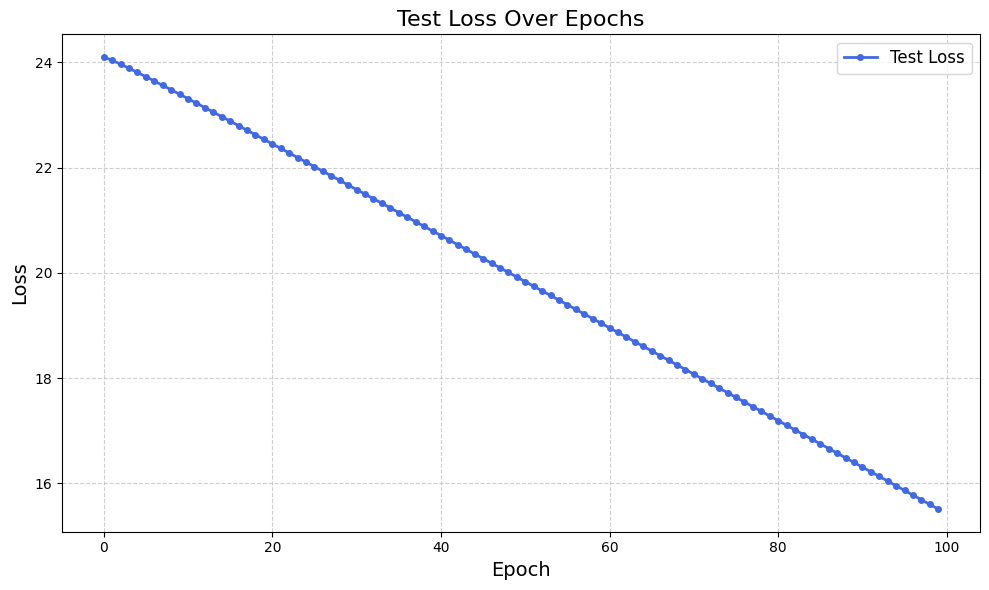

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(test_losses, label='Test Loss', color='royalblue', linewidth=2, marker='o', markersize=4)

plt.title("Test Loss Over Epochs", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig("../results/training/Model_D_(finetuned)_test_loss.png", dpi=300)
plt.show()